In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 200)

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import clone

In [2]:
df = pd.read_csv('housing_clean.csv', index_col=0)
df.shape

(2374, 98)

### Dummify Nominal Features

In [3]:
categ_nom = ['MSSubClass','BldgType','HouseStyle','SaleType','SaleCondition','MiscFeature',
             'Fence','GarageType','RoofStyle','RoofMatl','exterior_covering','MasVnrType',
             'MSZoning','Street','LotShape','LandContour','LotConfig','LandSlope','Neighborhood',
             'Alley','condition','Foundation','Utilities','Heating','CentralAir','MoSold','Electrical','QrtSold']

In [4]:
df = pd.get_dummies(df, columns=categ_nom, drop_first=True)

### Remove original columns that have been ordinalized

In [5]:
df = df.drop(columns=[col for col in df.columns if col.endswith('_todrop')])

### Setting up a baseline model before any tuning

* **Set a fair baseline:** Train a plain (untuned) Gradient Boosting model to get a reference R² you can compare against after tuning.
* **Reduce split luck:** Repeat the train/test split multiple times and **average** the R² so your baseline isn’t driven by a single “easy” or “hard” split.
* **Balance difficulty:** Use **StratifiedShuffleSplit** on **binned SalePrice** so each split has similar price-range distributions (no fold gets all the mansions).
* **Isolate variability:** Fix the model’s `random_state` so differences come from the **data splits**, not extra model randomness.
* **Make comparisons honest:** Report mean ± std of train/test R² from these repeats; tuning “wins” only if it beats this baseline by more than the noise.

In [6]:
y = df['SalePrice'];
x = df.drop(['SalePrice', 'PID'], axis = 1)

In [19]:
gbr = GradientBoostingRegressor()

GradientBoostingRegressor(random_state=0)

In [161]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10);


gbr.fit(x_train, y_train)

GradientBoostingRegressor()

In [172]:
# make sure each split has a balanced price range
# ---- your inputs ----
# x: features (DataFrame or ndarray)
# y: target (Series or ndarray)
# gbr: your base GradientBoostingRegressor (no tuning)

n_splits  = 20      # repeat 20 times
test_size = 0.30
n_bins    = 10      # deciles; reduce to 6–8 if bins get too small

# 1) Bin target into quantiles for stratification
y_series = pd.Series(y).reset_index(drop=True)
y_bins = pd.qcut(y_series, q=n_bins, labels=False, duplicates="drop")

# 2) Repeated stratified holdouts (balanced price ranges)
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)

train_scores, test_scores = [], []
for tr_idx, te_idx in sss.split(np.zeros(len(y_series)), y_bins):
    # slice X and y (works for both DataFrame and ndarray)
    X_tr = x.iloc[tr_idx] if hasattr(x, "iloc") else x[tr_idx]
    X_te = x.iloc[te_idx] if hasattr(x, "iloc") else x[te_idx]
    y_tr, y_te = y_series.iloc[tr_idx].values, y_series.iloc[te_idx].values

    model = clone(gbr).set_params(random_state=0)  # fix model RNG; isolates split variability
    model.fit(X_tr, y_tr)

    train_scores.append(model.score(X_tr, y_tr))
    test_scores.append(r2_score(y_te, model.predict(X_te)))
    
    test_r2_baseline = np.mean(test_scores)

print(f"Train R² before tuning: mean={np.mean(train_scores):.4f} ± {np.std(train_scores):.4f}")
print(f"Test  R² before tuning: mean={np.mean(test_scores):.4f} ± {np.std(test_scores):.4f}")
print("Per-split test R²:", np.round(test_scores, 4))

Train R² before tuning: mean=0.9728 ± 0.0015
Test  R² before tuning: mean=0.8946 ± 0.0366
Per-split test R²: [0.9304 0.9138 0.928  0.9247 0.9175 0.8384 0.8313 0.8709 0.8544 0.8471
 0.9236 0.8615 0.9295 0.9138 0.9241 0.9296 0.8494 0.9161 0.9318 0.856 ]


In [174]:
feature_importance = pd.DataFrame({"Features": x.columns, "Importance":gbr.feature_importances_})

In [175]:
feature_importance.sort_values("Importance", ascending = False, inplace=True);
feature_importance.head(10)

,Features,Importance
3,OverallQual,0.469166
0,GrLivArea,0.146732
12,1stFlrSF,0.051043
11,TotalBsmtSF,0.036957
47,ExterQual_ordinal,0.036573
25,GarageArea,0.036077
5,YearBuilt,0.026914
8,BsmtFinSF1,0.025743
2,LotArea,0.022835
13,2ndFlrSF,0.016459


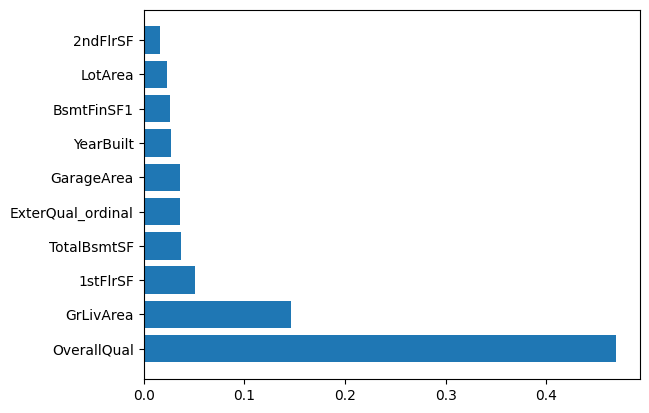

In [176]:
temp = feature_importance.iloc[:10,]
plt.barh(temp["Features"], temp["Importance"]);

### Setting parameter grid

In [177]:
param_grid = {
    'loss':['huber'], # dataset has outlier so use huber might be better
    'alpha':[0.85, 0.95], # alpha = 0.95 means top 5% largest residuals are treated linearly, only matter if loss is huber
    'n_estimators': range(100, 200, 50),
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [3, 4],
#     'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [20, 30, 40],
    'subsample':[0.7, 0.8, 0.9],
    'max_features': [0.5]
}

### Initialize Model and Grid Search

In [178]:
gbr = GradientBoostingRegressor()

# if done repeated CV in this step sometimes it takes a bit too long for 0.01% increase in R square test score
# --- repeated CV: 5 folds, 5 repeats ---
#rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

grid_search_gbr = GridSearchCV(estimator=gbr,
                           param_grid=param_grid,
                           cv=5,
                           #cv=rkf,
                           n_jobs=-1,
                           verbose=0,
                           scoring='r2')

grid_search_gbr.fit(x_train, y_train)
%time grid_search_gbr.fit(x_train, y_train)

CPU times: user 2.69 s, sys: 1.04 s, total: 3.73 s
Wall time: 1min 20s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'alpha': [0.85, 0.95],
                         'learning_rate': [0.03, 0.05, 0.1], 'loss': ['huber'],
                         'max_depth': [3, 4], 'max_features': [0.5],
                         'min_samples_leaf': [20, 30, 40],
                         'n_estimators': range(100, 200, 50),
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='r2')

### View the best parameters and score

In [179]:
print("Best Parameters:", grid_search_gbr.best_params_)
print("Best Score R square:", grid_search_gbr.best_score_)

Best Parameters: {'alpha': 0.85, 'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 4, 'max_features': 0.5, 'min_samples_leaf': 20, 'n_estimators': 150, 'subsample': 0.9}
Best Score R square: 0.9085871617346715


In [180]:
best_gbr = grid_search_gbr.best_estimator_

In [181]:
best_gbr.get_params()

{'alpha': 0.85,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'huber',
 'max_depth': 4,
 'max_features': 0.5,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 20,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 0.9,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [182]:
best_gbr

GradientBoostingRegressor(alpha=0.85, loss='huber', max_depth=4,
                          max_features=0.5, min_samples_leaf=20,
                          n_estimators=150, subsample=0.9)

### Evaluate on Test Set

In [222]:
final_gbr = best_gbr.fit(x_train, y_train)

In [223]:
y_train_pred = final_gbr.predict(x_train)
y_test_pred = final_gbr.predict(x_test)

In [224]:
# R2
r2_5kf_train = final_gbr.score(x_train, y_train)
r2_5kf_test = final_gbr.score(x_test, y_test)

In [225]:
print(f"Train R square: {r2_5kf_train:.4f}")
print(f"Test R square: {r2_5kf_test:.4f}") 

Train R square: 0.9521
Test R square: 0.9315


In [226]:
# root mean squared error, lower is better
# sensitive to outliers
# tells you the average size of the error in prediction — in dollar terms
rmse_5kf_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_5kf_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

In [227]:
print(f"Train Root Mean Squared Error: {rmse_5kf_train:.2f}")
print(f"Test Root Mean Squared Error: {rmse_5kf_test:.2f}")

Train Root Mean Squared Error: 16447.97
Test Root Mean Squared Error: 19887.92


In [228]:
gbr_feature_importance_final = pd.DataFrame({"feature": x.columns, 
                                            "importance_gbr_5fk":final_gbr.feature_importances_})

In [229]:
gbr_feature_importance_final

,feature,importance_gbr_5fk
0,GrLivArea,0.140682
1,LotFrontage,0.004151
2,LotArea,0.028942
3,OverallQual,0.259634
4,OverallCond,0.007330
...,...,...
276,Electrical_FuseP,0.000000
277,Electrical_SBrkr,0.000000
278,QrtSold_Q2,0.000112
279,QrtSold_Q3,0.000000


In [192]:
gbr_feature_importance_final.sort_values("importance_gbr_5fk", ascending = False, inplace=True);
gbr_feature_importance_final.head(10)

,feature,importance_gbr_5fk
5,YearBuilt,0.228448
3,OverallQual,0.183374
0,GrLivArea,0.165429
12,1stFlrSF,0.044653
42,BsmtQual_ordinal,0.044153
47,ExterQual_ordinal,0.043606
11,TotalBsmtSF,0.043515
25,GarageArea,0.035383
2,LotArea,0.033104
22,Fireplaces,0.020021


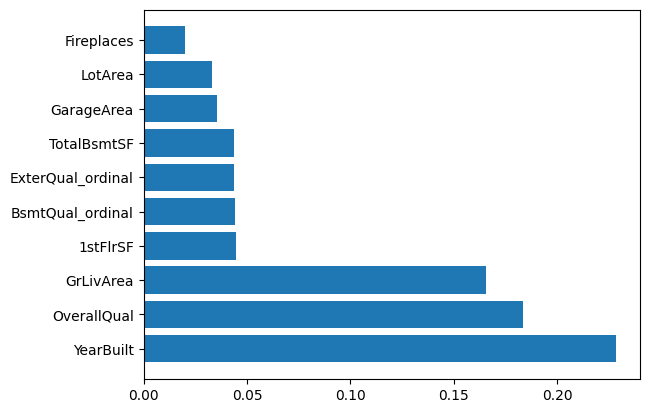

In [193]:
temp = gbr_feature_importance_final.iloc[:10,]
plt.barh(temp["feature"], temp["importance_gbr_5fk"]);

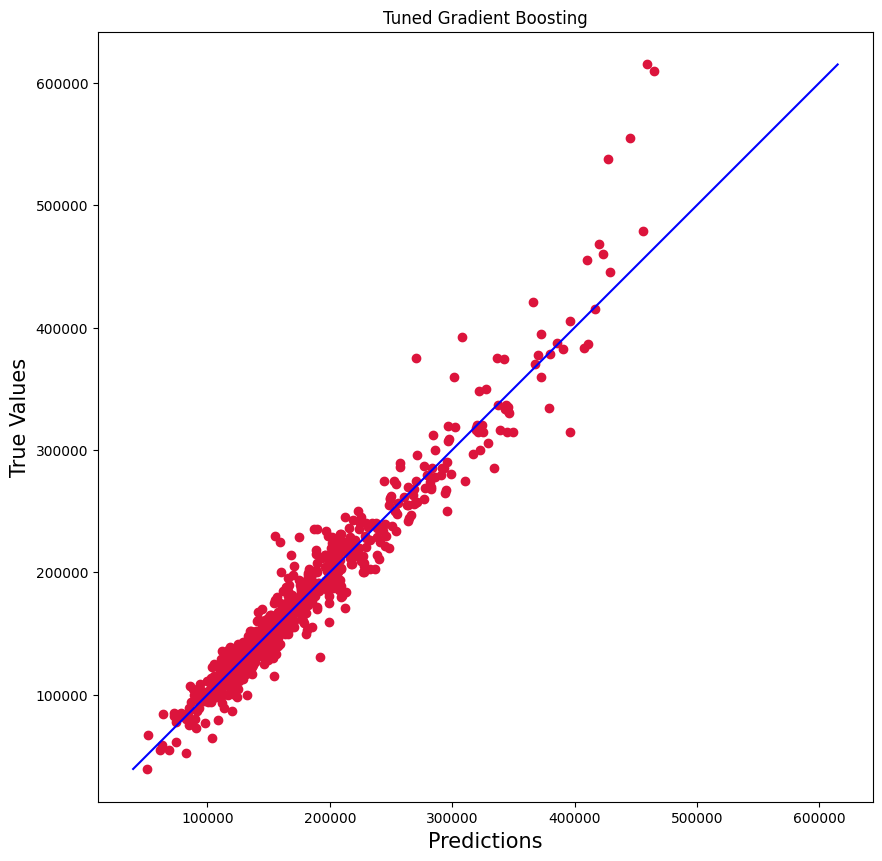

In [194]:
plt.figure(figsize=(10,10))
plt.scatter(y_test_pred, y_test, c='crimson')

plt.title('Tuned Gradient Boosting')
p1 = max(max(y_test_pred), max(y_test))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('True Values', fontsize=15)
plt.axis('equal')
plt.show()

### Repeating K fold to find the average score

In [203]:
# here we are not changing the hyperparameter that have been determined in the CV process above
# instead of just finding the CV score by perform the 5 fold once, we repeat it multiple times and find the avg

# Define repeated CV: 5 folds, repeated 10 times (50 scores total)
rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

cv_scores = cross_val_score(best_gbr, x_train, y_train, cv=rkf, scoring="r2")

print('Mean CV R²:', np.mean(cv_scores))
print('Std CV R²:', np.std(cv_scores))
print('Test R²:',r2_5kf_test)

Mean CV R²: 0.9109322530974253
Std CV R²: 0.04348677339377955
Test R²: 0.9377365479076534


### Check the stability of the model by comparing fold-wise CV R square to test R square. Findings:
- Our model generalizes well because the red line is above the blue dashed line from below
- R square improved under our tuned model compared to baseline model
- If red line < blue dashed line → possible overfitting or unlucky test split.
- If blue dots are very spread out → model has high variance (performance sensitive to data splits).

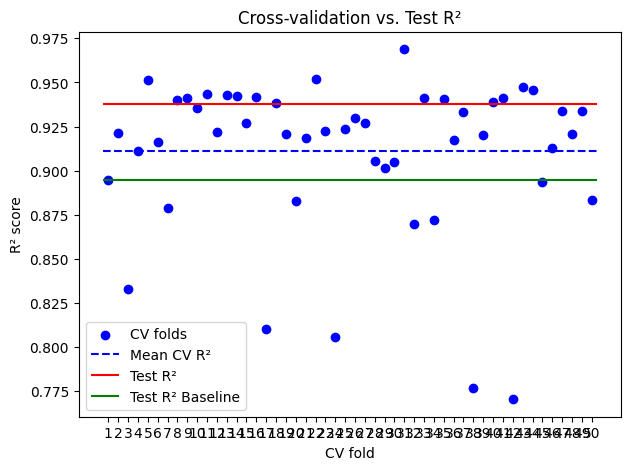

In [221]:
# plot comparison
plt.figure(figsize=(7,5))

# Plot CV fold scores
plt.scatter(range(1, len(cv_scores)+1), cv_scores, color="blue", label="CV folds")
plt.hlines(np.mean(cv_scores), 0.5, len(cv_scores)+0.5, colors="blue", linestyles="dashed", label="Mean CV R²")

# Plot test score
plt.hlines(r2_5kf_test, 0.5, len(cv_scores)+0.5, colors="red", linestyles="solid", label="Test R²")
plt.hlines(test_r2_baseline, 0.5, len(cv_scores)+0.5, colors="green", linestyles="solid", label="Test R² Baseline")

plt.xticks(range(1, len(cv_scores)+1))
plt.xlabel("CV fold")
plt.ylabel("R² score")
plt.title("Cross-validation vs. Test R²")
plt.legend()
plt.show()


### How to read below boxplot? Our model performance is consistent with CV.
- Box (blue): spread of R² across folds (median, quartiles, whiskers).
- Red dot: test R².
- If the red dot sits inside or near the box, test performance is consistent with CV.
- If the red dot is well above the box, your test set is easier.
- If the red dot is well below the box, the model may be overfitting or the test set is harder.

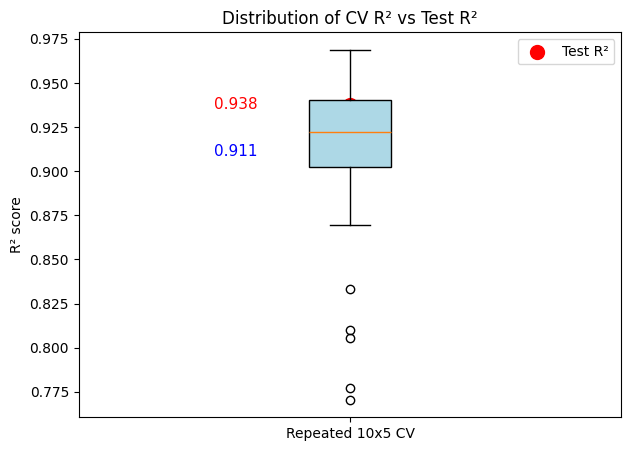

In [220]:
# visualize distribution vs test
plt.figure(figsize=(7,5))

# Boxplot of repeated CV scores
plt.boxplot(cv_scores, vert=True, patch_artist=True,
            boxprops=dict(facecolor="lightblue"))
plt.scatter(1, r2_5kf_test, color="red", s=100, marker="o", label="Test R²")

# Annotate the test R² value
plt.text(0.75, r2_5kf_test, f"{r2_5kf_test:.3f}", color="red", va="center", fontsize=11)

# Annotate mean CV R² value
cv_mean = np.mean(cv_scores)
plt.text(0.75, cv_mean, f"{cv_mean:.3f}", color="blue", va="center", fontsize=11)

# Labels
plt.xticks([1], ["Repeated 10x5 CV"])
plt.ylabel("R² score")
plt.title("Distribution of CV R² vs Test R²")
plt.legend()
plt.show()

### Test R square is within 1 SD of mean CV score

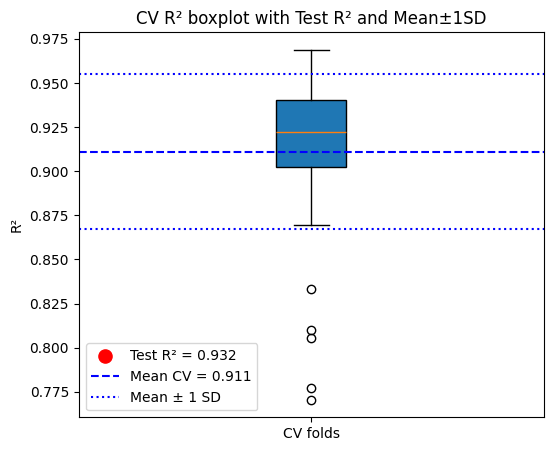

In [230]:
# import numpy as np
# import matplotlib.pyplot as plt

cv = np.array(cv_scores)           # your fold-wise R²s
test = r2_5kf_test

mean, sd = cv.mean(), cv.std(ddof=1)

plt.figure(figsize=(6,5))
plt.boxplot(cv, vert=True, patch_artist=True)
plt.scatter(1, test, s=90, color="red", label=f"Test R² = {test:.3f}")

# mean and ±1 SD lines
plt.axhline(mean, linestyle="--", color="blue", label=f"Mean CV = {mean:.3f}")
plt.axhline(mean - sd, linestyle=":", color="blue", label="Mean ± 1 SD")
plt.axhline(mean + sd, linestyle=":", color="blue")

plt.xticks([1], ["CV folds"])
plt.ylabel("R²")
plt.title("CV R² boxplot with Test R² and Mean±1SD")
plt.legend()
plt.show()

### SHAP
- A SHAP value tells you how much a particular feature pushes the model’s predicted house price up or down, compared to the average prediction across the dataset.

In [ ]:
# Say the average predicted price is $200,000
# If for House A, the SHAP value for GrLivArea is +15,000, 
# that means the model believes the GrLivArea of House A contributes +$15,000 to the price, 
# compared to the average. If for House B, the SHAP value is -5,000, 
# that means the GrLivArea of House B is lowering the prediction by $5,000 from the average.

In [208]:
import shap

# Fit explainer on train data
explainer = shap.Explainer(final_gbr)

# Evaluate SHAP values on test set
shap_values = explainer.shap_values(x_test)

#This balances accurate attribution with realistic performance evaluation.

In [210]:
# SHAP feature importance
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for easier viewing and sorting
shap_importance = pd.DataFrame({
    'feature': x.columns,
    'mean_abs_shap_gbr_5fk': mean_abs_shap_values
})

# Sort in descending order
shap_importance_sorted = shap_importance.sort_values(by='mean_abs_shap_gbr_5fk', ascending=False)

# Display
print(shap_importance_sorted.head(30))

# how to interpret:
# # On average, the feature OverallQual changes the model’s prediction by 14,566 units of currency (likely dollars), 
# either increasing or decreasing the predicted house price.

                  feature  mean_abs_shap_gbr_5fk
0               GrLivArea           15443.348984
3             OverallQual           13232.615766
5               YearBuilt            9619.939430
11            TotalBsmtSF            5484.605641
2                 LotArea            4063.752156
12               1stFlrSF            3705.015952
47      ExterQual_ordinal            3674.824713
8              BsmtFinSF1            3292.170760
41    KitchenQual_ordinal            3031.718515
25             GarageArea            2686.793763
6            YearRemodAdd            2552.090663
4             OverallCond            2497.742599
42       BsmtQual_ordinal            2399.282290
38    FireplaceQu_ordinal            2181.410950
34   GarageFinish_ordinal            1879.033221
45   BsmtFinType1_ordinal            1511.328772
22             Fireplaces            1378.276212
15           BsmtFullBath            1370.130330
44   BsmtExposure_ordinal            1226.178710
17               Ful

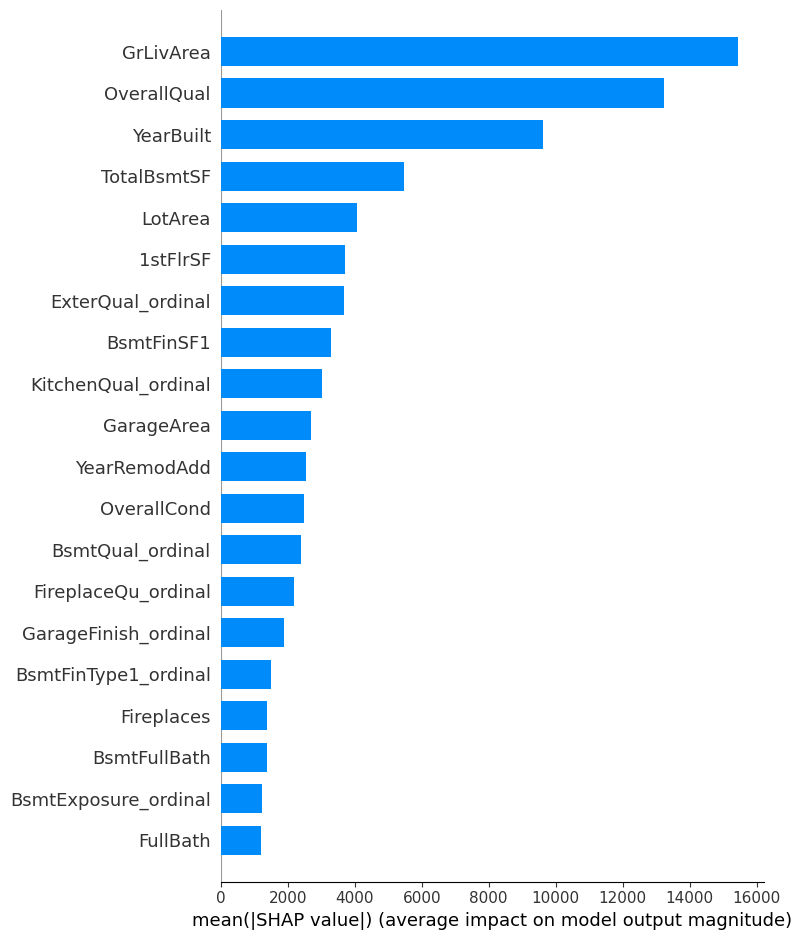

In [211]:
# to visualize the mean abs of SHAP value using summary bar plot
shap.summary_plot(shap_values, x_test, plot_type='bar')

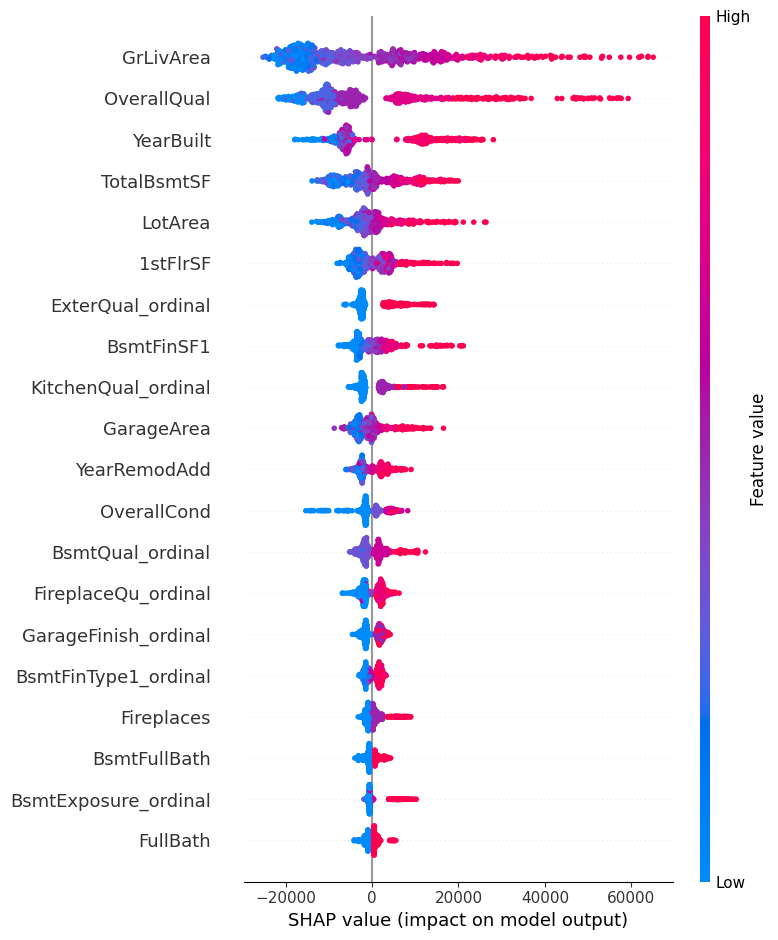

In [212]:
# summary violin plot
shap.summary_plot(shap_values, x_test)

In [ ]:
# How to Read the Violin Plot
# ✅ 1. Width of the Violin (Horizontal Spread)

# Wider areas indicate more data points with similar SHAP values.

# This shows the distribution of how much that feature affects predictions across your dataset.

# ✅ 2. Color Gradient (Red → Blue)

# Each dot is colored by the actual value of the feature:

# Red = High feature value

# Blue = Low feature value

# This helps you understand the direction of the effect.

# For example, if red dots are mostly on the right (positive SHAP values), high values of that feature increase the prediction (e.g., higher price).

# If blue dots are on the left (negative SHAP values), low values decrease the prediction.

# ✅ 3. X-Axis (SHAP Value)

# Represents the magnitude and direction of impact on the model’s prediction.

# A value of +5000 means the feature adds $5,000 (for a house price model).

# A value of -3000 means it subtracts $3,000 from the prediction.

### SHAP Dependence Plot
- In a SHAP dependence plot, the x-axis shows the value of the feature you specified, and the y-axis shows the SHAP value (i.e., the feature’s contribution to the model output). But if you’re seeing a second feature encoded on the plot, that’s expected and by design. The second feature (by color) is there to show interactions. The SHAP dependence plot automatically colors the points by the most correlated feature with the one on the x-axis. This helps uncover interactions between features.

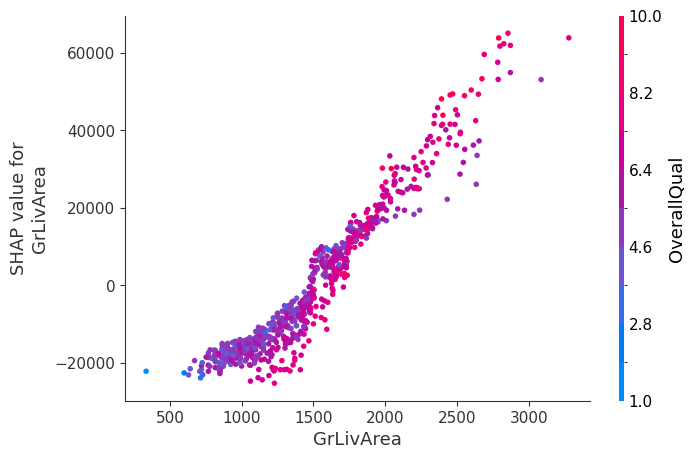

In [213]:
shap.dependence_plot('GrLivArea', shap_values, x_test)

# if don't want to show the second y-axis
#shap.dependence_plot('GrLivArea', shap_values, x_test, interaction_index=None)

<Figure size 600x400 with 0 Axes>

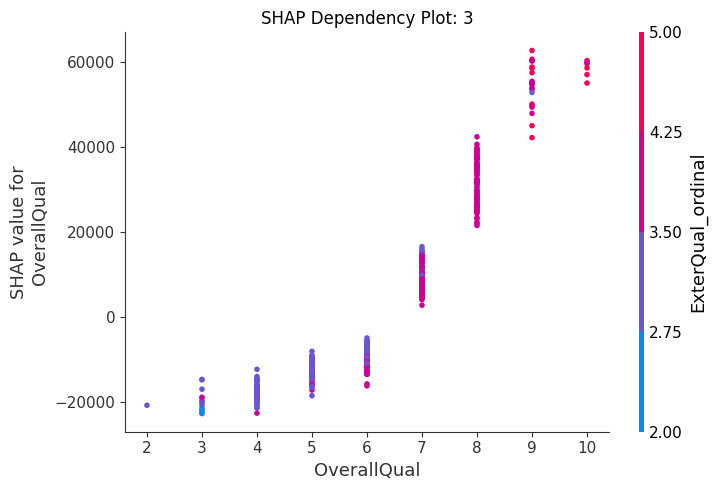

<Figure size 600x400 with 0 Axes>

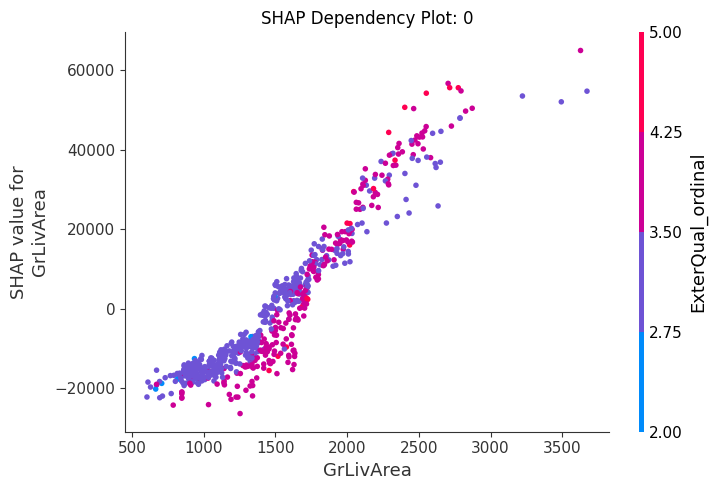

<Figure size 600x400 with 0 Axes>

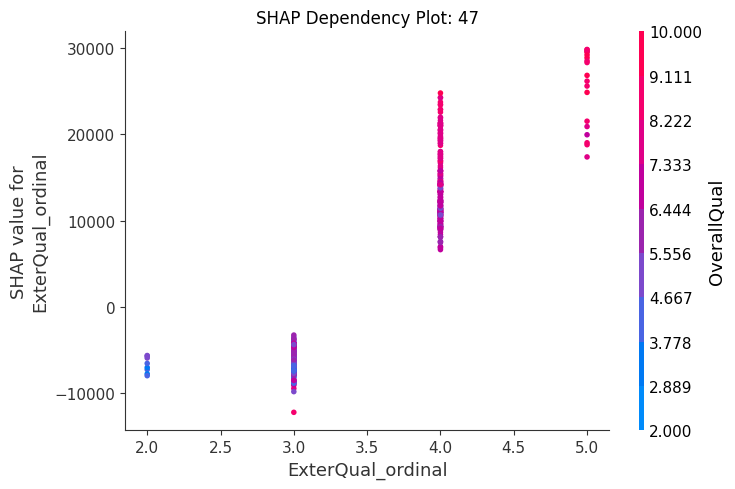

<Figure size 600x400 with 0 Axes>

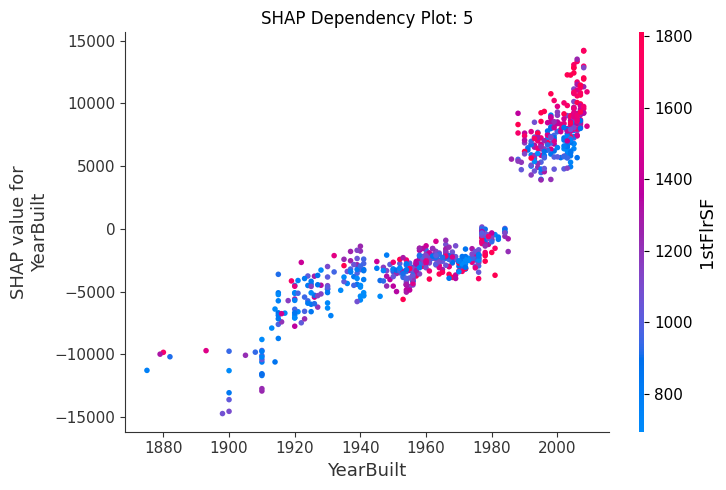

<Figure size 600x400 with 0 Axes>

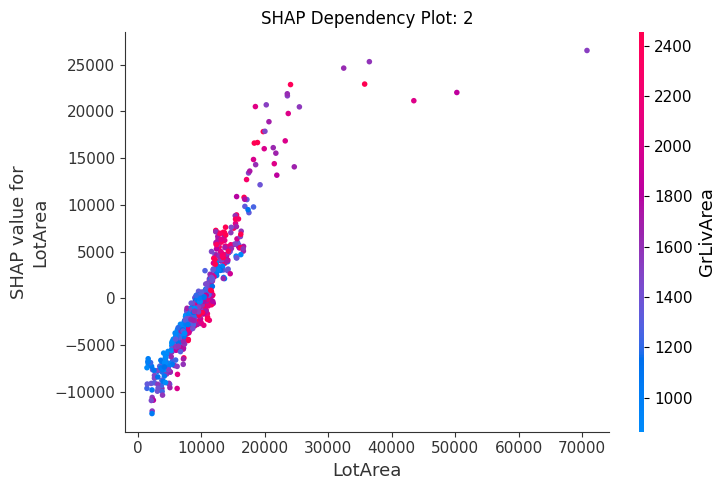

<Figure size 600x400 with 0 Axes>

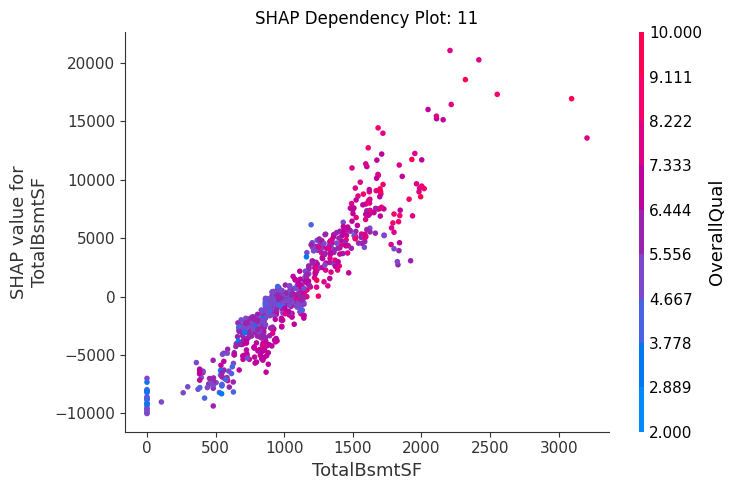

<Figure size 600x400 with 0 Axes>

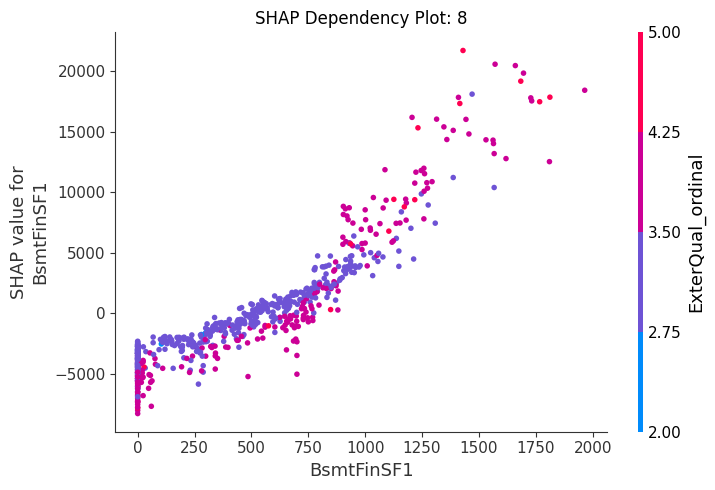

<Figure size 600x400 with 0 Axes>

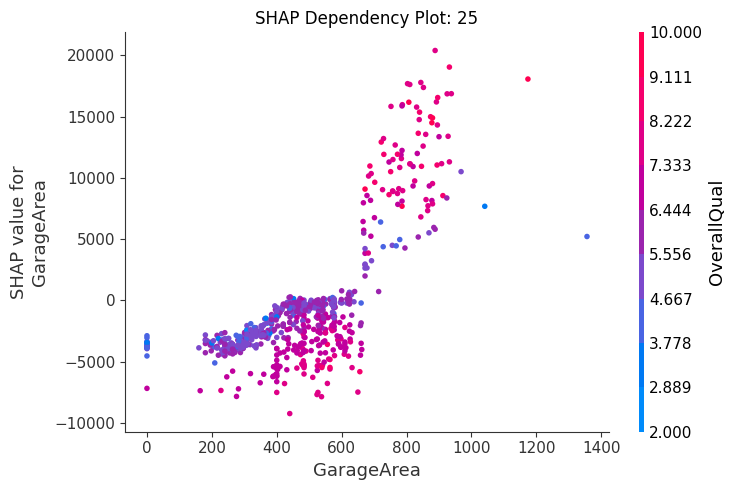

<Figure size 600x400 with 0 Axes>

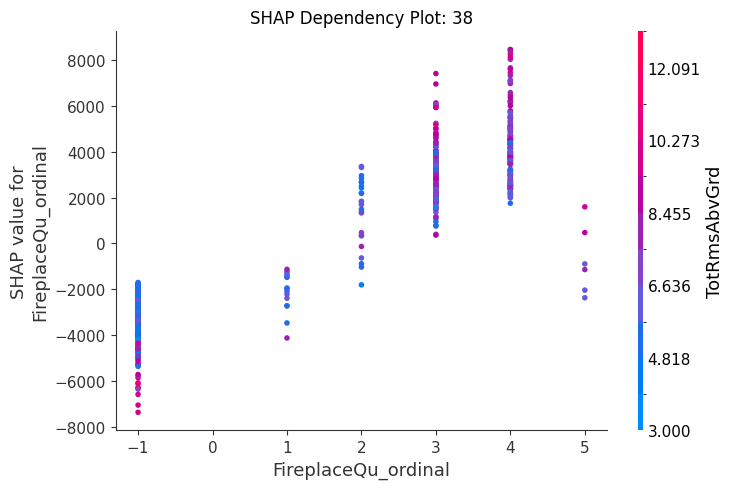

<Figure size 600x400 with 0 Axes>

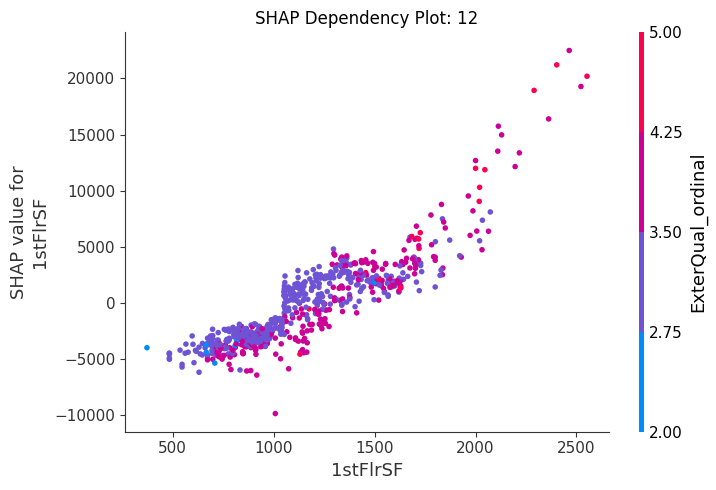

<Figure size 600x400 with 0 Axes>

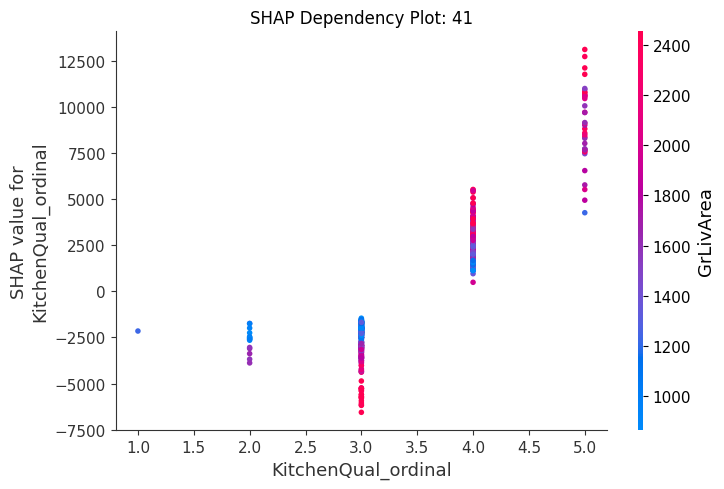

<Figure size 600x400 with 0 Axes>

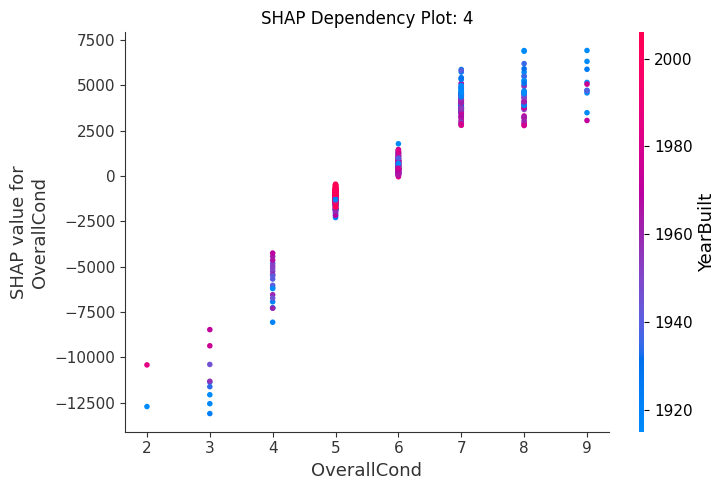

<Figure size 600x400 with 0 Axes>

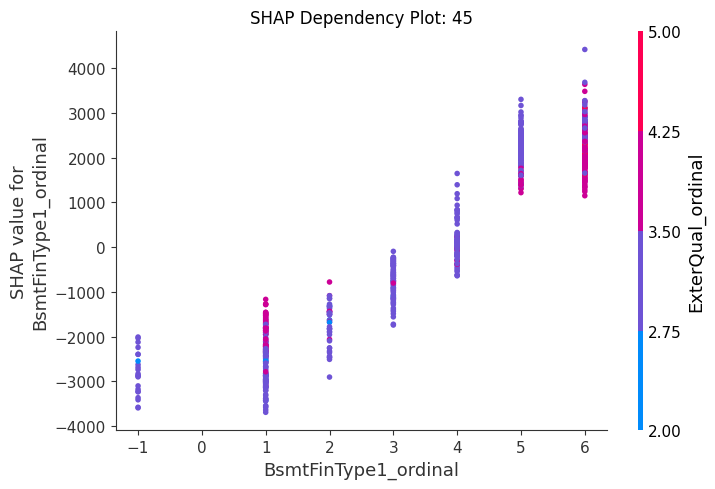

<Figure size 600x400 with 0 Axes>

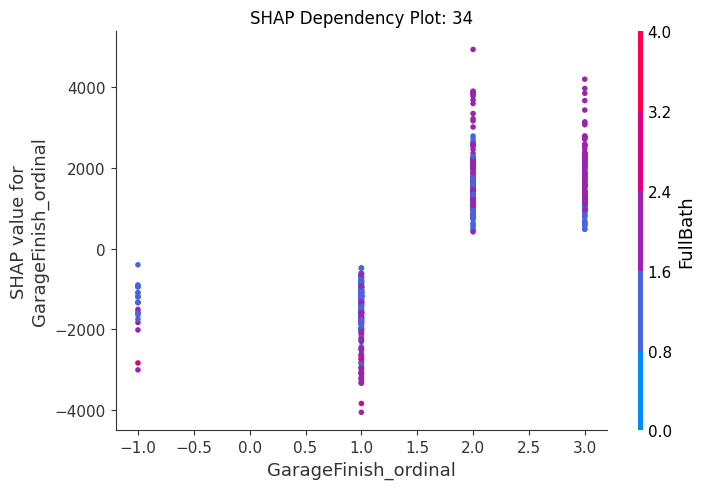

<Figure size 600x400 with 0 Axes>

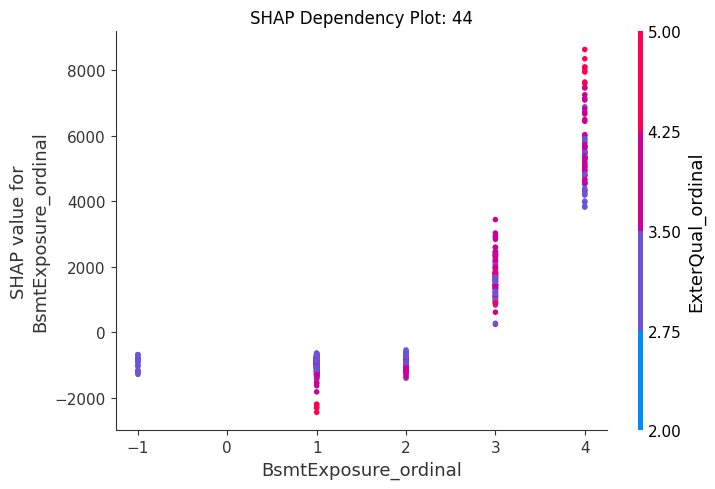

<Figure size 600x400 with 0 Axes>

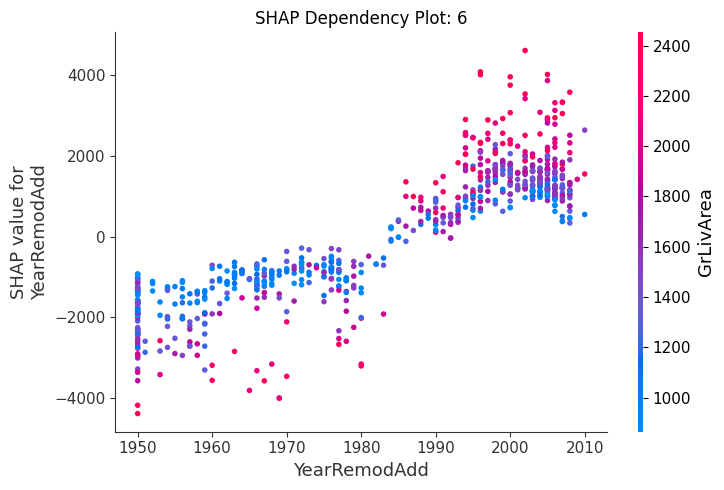

<Figure size 600x400 with 0 Axes>

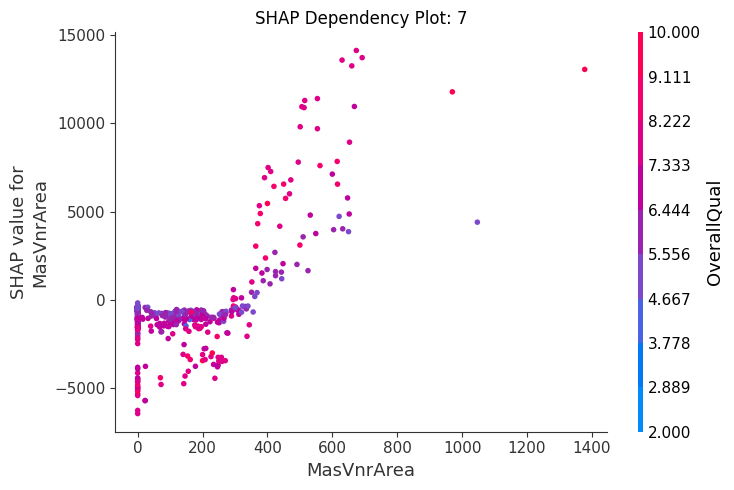

<Figure size 600x400 with 0 Axes>

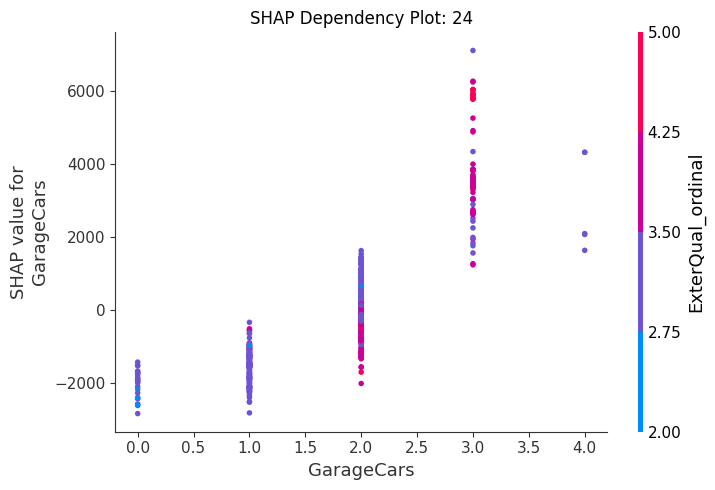

<Figure size 600x400 with 0 Axes>

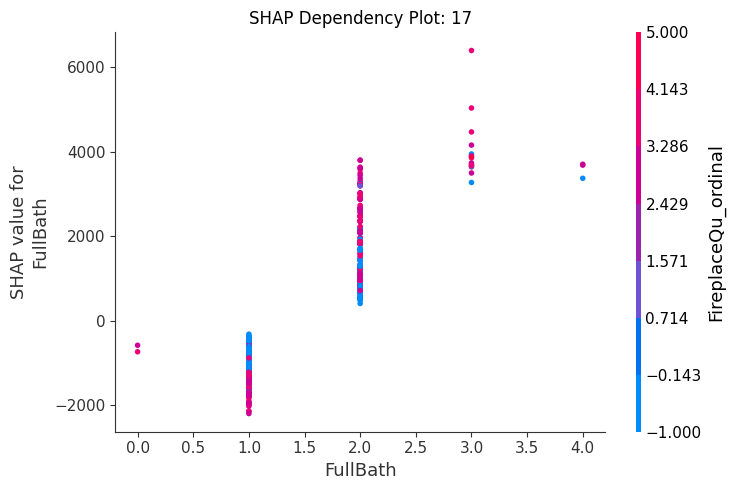

<Figure size 600x400 with 0 Axes>

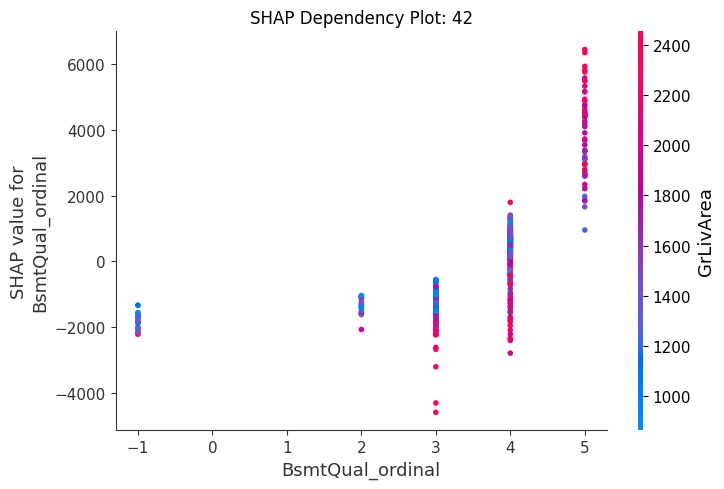

In [119]:
# Select top 20 features
top_features = shap_importance_sorted.head(20).index.tolist()

for feature in top_features:
    plt.figure(figsize=(6, 4))  # Compact size
    
    shap.dependence_plot(
        feature,
        shap_values,
        x_test,
        #interaction_index=None,  # Auto-picks a good feature for color encoding
        show=False
    )
    plt.title(f"SHAP Dependency Plot: {feature}")
    plt.tight_layout()
    plt.show()
    
    # Save plot to file
#     filename = f"shap_dependency_{feature}.png"
#     plt.savefig(filename, dpi=150)
#     plt.close()

# how to interpret
# using OverallQual as an example,
# 1stFlrSF is the most correlated feature with Overall
# you can see larger homes with high OverallQual have even higher SHAP values (strong positive synergy).
# Conversely, small homes (blue dots) with high OverallQual may still not be valued as highly.

### Export lists for final model comparison

### Extract the list of features and features that each one is most correlated with

In [214]:
# Compute correlation matrix for SHAP dependency plot coloring
cor_matrix = x_test.corr()

In [215]:
most_correlated = {}

for feature in x_test.columns:
    # Exclude self-correlation
    corrs = cor_matrix[feature].drop(labels=[feature])
    
    # Drop NaNs
    corrs = corrs.dropna()
    
    # Get feature with highest absolute correlation
    if not corrs.empty:
        most_correlated_feature = corrs.abs().idxmax()
        most_correlated[feature] = most_correlated_feature


In [216]:
correlation_df = pd.DataFrame.from_dict(most_correlated, orient='index', columns=['Most_Correlated_Feature'])
correlation_df.reset_index(inplace=True)
correlation_df.columns = ['feature', 'most_correlated_feature_gbr_5fk']

In [217]:
correlation_df

,feature,most_correlated_feature_gbr_5fk
0,GrLivArea,TotRmsAbvGrd
1,LotFrontage,1stFlrSF
2,LotArea,LandSlope_Sev
3,OverallQual,ExterQual_ordinal
4,OverallCond,ExterCond_ordinal
...,...,...
226,Electrical_FuseP,LotShape_IR3
227,Electrical_SBrkr,Electrical_FuseF
228,QrtSold_Q2,MoSold_6
229,QrtSold_Q3,MoSold_7


In [218]:
# limit the above list to top 20 features ranked by mean abs SHAP values
rf_SHAP_feature_final = pd.merge(
    shap_importance_sorted, 
    correlation_df, 
    how='left',
    on = 'feature'
)

rf_SHAP_feature_final

,feature,mean_abs_shap_gbr_5fk,most_correlated_feature_gbr_5fk
0,GrLivArea,15443.348984,TotRmsAbvGrd
1,OverallQual,13232.615766,ExterQual_ordinal
2,YearBuilt,9619.939430,OverallQual
3,TotalBsmtSF,5484.605641,1stFlrSF
4,LotArea,4063.752156,LandSlope_Sev
...,...,...,...
276,exterior_covering_MetalSd_HdBoard,0.000000,condition_Feedr_Norm
277,exterior_covering_MetalSd_Stucco,0.000000,NaN
278,exterior_covering_MetalSd_VinylSd,0.000000,Neighborhood_BrkSide
279,exterior_covering_MetalSd_Wd Sdng,0.000000,NaN


In [219]:
gbr_feature_importance_final

,feature,importance_gbr_5fk
5,YearBuilt,0.228448
3,OverallQual,0.183374
0,GrLivArea,0.165429
12,1stFlrSF,0.044653
42,BsmtQual_ordinal,0.044153
...,...,...
230,Neighborhood_Timber,0.000000
231,Neighborhood_Veenker,0.000000
232,Alley_Pave,0.000000
234,condition_Artery_PosA,0.000000
